In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import urllib.request

def download(url, output) : 
    if not os.path.exists(output):
        print(f"{output} not found. Downloading...")
        urllib.request.urlretrieve(url, output)
    else:
        print(f"{output} already exists. Skip download.")

download("https://drive.google.com/uc?id=1JPOVfYXJNXeBgG_V0auiuK5W2CvP4_td", "training.csv")
download("https://drive.google.com/uc?id=11W8QiL98fEqV7Xfbw-xgXCC7G-SM1yMb", "test.csv")

NameError: name 'os' is not defined

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,097 (16.00 KB)

 Trainable params: 4,097 (16.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.8033 - auc: 0.8721 - loss: 0.4205 - val_accuracy: 0.8273 - val_auc: 0.8954 - val_loss: 0.3843
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - accuracy: 0.8341 - auc: 0.9011 - loss: 0.3737 - val_accuracy: 0.8343 - val_auc: 0.9020 - val_loss: 0.3731
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - accuracy: 0.8370 - auc: 0.9048 - loss: 0.3665 - val_accuracy: 0.8355 - val_auc: 0.9040 - val_loss: 0.3684
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - accuracy: 0.8382 - auc: 0.9067 - loss: 0.3626 - val_accuracy: 0.8372 - val_auc: 0.9052 - val_loss: 0.3666
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - accuracy: 0.8399 - auc: 0.9080 - loss: 0.3598 - val_accuracy: 0.8369 - val_auc: 0.9053 - val_loss: 0.3660
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - accuracy: 0.8407 - auc: 0.9088 - loss: 0.3582 - val_accuracy: 0.8374 - val_auc: 0.9069 - val_loss: 0.3626
Epoch 7/20
782/782 ━━━━━━━━━

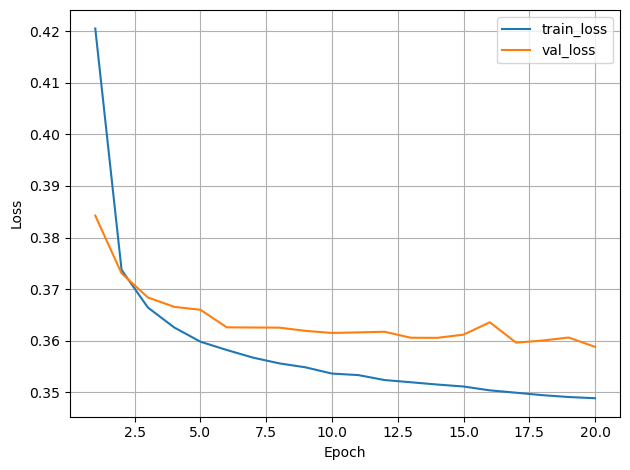

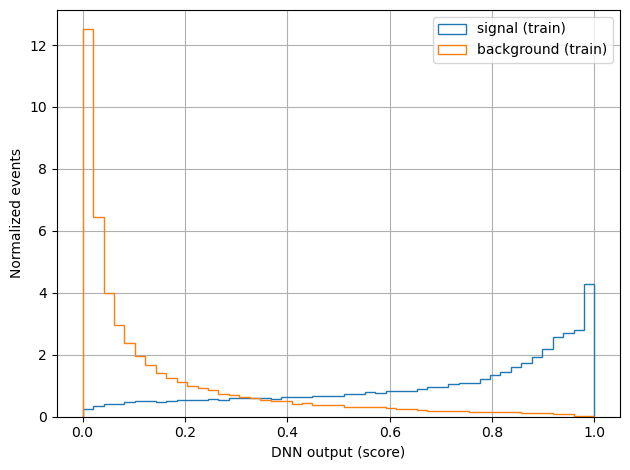

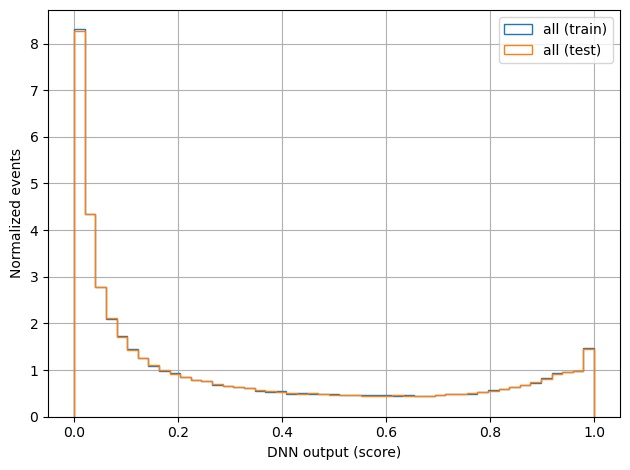

In [ ]:
# ===== データ読み込み =====
df = pd.read_csv("training.csv")

# ラベル (s→1, b→0)
y = (df["Label"] == "s").astype(int).values

# 特徴量 (EventId, Weight, Label を除く)
X = df.drop(columns=["EventId", "Weight", "Label"]).values

# ===== 欠損値処理 (-999 を NaN とみなして median で埋める) =====
X = np.where(X == -999.0, np.nan, X)
imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(X)

# ===== train / validation 分割 =====
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ===== スケーリング =====
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# ===== DNN モデル定義 =====
input_dim = X_train.shape[1]

model = keras.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(64, activation="relu"),
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid"),  # 2値分類 → 出力1, sigmoid
])

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")]
)

model.summary()

# ===== 学習 =====
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=256,
    verbose=1,
)

# ===== validation 評価 =====
val_loss, val_acc, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"val_acc = {val_acc:.3f}, val_auc = {val_auc:.3f}")

# =========================================================
# ここから追加： test.csv の評価 ＆ 各種プロット
# =========================================================

# ===== test.csv 読み込み =====
df_test = pd.read_csv("test.csv")

# test に Label があるかどうかで場合分け
has_test_label = "Label" in df_test.columns

if has_test_label:
    y_test = (df_test["Label"] == "s").astype(int).values
    X_test_raw = df_test.drop(columns=["EventId", "Weight", "Label"]).values
else:
    y_test = None
    X_test_raw = df_test.drop(columns=["EventId", "Weight"], errors="ignore").values

# test 側の -999 → NaN, その後 imputer / scaler を train と同じもので適用
X_test_raw = np.where(X_test_raw == -999.0, np.nan, X_test_raw)
X_test_imp = imputer.transform(X_test_raw)
X_test = scaler.transform(X_test_imp)

# ===== test 評価（Label がある場合のみ） =====
if y_test is not None:
    test_loss, test_acc, test_auc = model.evaluate(X_test, y_test, verbose=0)
    print(f"test_acc = {test_acc:.3f}, test_auc = {test_auc:.3f}")
else:
    print("test.csv に Label カラムが無いので、test loss/accuracy の評価はスキップします。")

# ===== loss vs epoch (train / val) =====
plt.figure()
epochs = range(1, len(history.history["loss"]) + 1)
plt.plot(epochs, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")

# （オプション）test loss がある場合は水平線で表示
if y_test is not None:
    plt.axhline(test_loss, linestyle="--", label=f"test_loss = {test_loss:.3f}")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_epoch.png", dpi=150)
# plt.show()

# ===== BG / signal の classification score 分布 =====
# train / test をオーバーレイ

# 予測スコア（0〜1）
scores_train = model.predict(X_train, batch_size=4096).ravel()
scores_test  = model.predict(X_test,  batch_size=4096).ravel()

bins = np.linspace(0.0, 1.0, 50)

# --- (1) train 側の BG / signal 分布 ---
plt.figure()
plt.hist(
    scores_train[y_train == 1],
    bins=bins,
    histtype="step",
    density=True,
    label="signal (train)",
)
plt.hist(
    scores_train[y_train == 0],
    bins=bins,
    histtype="step",
    density=True,
    label="background (train)",
)
plt.xlabel("DNN output (score)")
plt.ylabel("Normalized events")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("score_dist_train_sig_bg.png", dpi=150)
# plt.show()

# --- (2) train / test オーバーレイ ---
# test に Label がある場合：signal / BG ごとに train vs test を比較
if y_test is not None:
    plt.figure(figsize=(10, 4))

    # 左：signal
    plt.subplot(1, 2, 1)
    plt.hist(
        scores_train[y_train == 1],
        bins=bins, histtype="step", density=True,
        label="signal (train)",
    )
    plt.hist(
        scores_test[y_test == 1],
        bins=bins, histtype="step", density=True,
        label="signal (test)",
    )
    plt.xlabel("DNN output (score)")
    plt.ylabel("Normalized events")
    plt.title("Signal")
    plt.legend()
    plt.grid(True)

    # 右：background
    plt.subplot(1, 2, 2)
    plt.hist(
        scores_train[y_train == 0],
        bins=bins, histtype="step", density=True,
        label="background (train)",
    )
    plt.hist(
        scores_test[y_test == 0],
        bins=bins, histtype="step", density=True,
        label="background (test)",
    )
    plt.xlabel("DNN output (score)")
    plt.ylabel("Normalized events")
    plt.title("Background")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("score_dist_train_vs_test_sig_bg.png", dpi=150)
    # plt.show()

else:
    # Label がない場合は「全イベント」の score 分布だけ test と比較
    plt.figure()
    plt.hist(
        scores_train,
        bins=bins, histtype="step", density=True,
        label="all (train)",
    )
    plt.hist(
        scores_test,
        bins=bins, histtype="step", density=True,
        label="all (test)",
    )
    plt.xlabel("DNN output (score)")
    plt.ylabel("Normalized events")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("score_dist_train_vs_test_all.png", dpi=150)
    # plt.show()